This notebook covers the use of 'holidays' in the Prophet forecasting library. In this notebook, we will extend the previous example (http://pythondata.com/forecasting-time-series-data-prophet-jupyter-notebook/) to use holidays in the forecasting.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

### Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [2]:
sales_df = pd.read_csv('data/retail_sales.csv', index_col='date', parse_dates=True)

In [3]:
sales_df.head()

,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022


### Prepare for Prophet

As explained in previous prophet posts, for prophet to work, we need to change the names of these columns to 'ds' and 'y'.

In [4]:
df = sales_df.reset_index()

In [5]:
df.head()

,date,sales
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [6]:
df=df.rename(columns={'date':'ds', 'sales':'y'})

In [7]:
df.head()

,ds,y
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

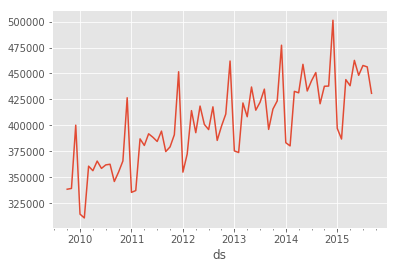

In [8]:
df.set_index('ds').y.plot()

### Reviewing the Data

We can see from this data that there is a spike in the same month each year. While spike could be due to many different reasons, let's assume its because there's a major promotion that this company runs every year at that time, which is in December for this dataset.

Because we know this promotion occurs every december, we want to use this knowledge to help prophet better forecast those months, so we'll use prohpet's ```holiday``` construct (explained here https://facebookincubator.github.io/prophet/docs/holiday_effects.html).

The holiday constrict is a pandas dataframe with the holiday and date of the holiday. For this example, the construct would look like this:

```promotions = pd.DataFrame({
  'holiday': 'december_promotion',
  'ds': pd.to_datetime(['2009-12-01', '2010-12-01', '2011-12-01', '2012-12-01',
                        '2013-12-01', '2014-12-01', '2015-12-01']),
  'lower_window': 0,
  'upper_window': 0,
})```

This ```promotions``` dataframe consisists of promotion dates for Dec in 2009 through 2015,  The ```lower_window``` and ```upper_window``` values are set to zero to indicate that we don't want prophet to consider any other months than the ones listed.


In [9]:
promotions = pd.DataFrame({
  'holiday': 'december_promotion',
  'ds': pd.to_datetime(['2009-12-01', '2010-12-01', '2011-12-01', '2012-12-01',
                        '2013-12-01', '2014-12-01', '2015-12-01']),
  'lower_window': 0,
  'upper_window': 0,
})

In [10]:
promotions

,ds,holiday,lower_window,upper_window
0,2009-12-01,december_promotion,0,0
1,2010-12-01,december_promotion,0,0
2,2011-12-01,december_promotion,0,0
3,2012-12-01,december_promotion,0,0
4,2013-12-01,december_promotion,0,0
5,2014-12-01,december_promotion,0,0
6,2015-12-01,december_promotion,0,0


To continue, we need to log-transform our data:

In [11]:
df['y'] = np.log(df['y'])

In [12]:
df.tail()

,ds,y
67,2015-05-01,13.044650
68,2015-06-01,13.013060
69,2015-07-01,13.033991
70,2015-08-01,13.030993
71,2015-09-01,12.973671


### Running Prophet

Now, let's set prophet up to begin modeling our data using our ```promotions``` dataframe as part of the forecast

Note: Since we are using monthly data, you'll see a message from Prophet saying ```Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.```  This is OK since we are workign with monthly data but you can disable it by using ```weekly_seasonality=True``` in the instantiation of Prophet.

In [13]:
model = Prophet(holidays=promotions)
model.fit(df);

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\pablo\Anaconda3\envs\cnb\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We've instantiated the model, now we need to build some future dates to forecast into.

In [14]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
91,2017-04-30
92,2017-05-31
93,2017-06-30
94,2017-07-31
95,2017-08-31


To forecast this future data, we need to run it through Prophet's model.

In [15]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [16]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,december_promotion,december_promotion_lower,december_promotion_upper,holidays,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
91,2017-04-30,13.055758,12.947175,13.157938,12.954292,13.168505,0.0,0.0,0.0,0.0,...,0.008213,0.008213,0.008213,0.008213,0.008213,0.008213,0.008213,0.008213,0.008213,13.063971
92,2017-05-31,13.057427,12.941003,13.168090,12.940685,13.168633,0.0,0.0,0.0,0.0,...,-0.000546,-0.000546,-0.000546,-0.000546,-0.000546,-0.000546,-0.000546,-0.000546,-0.000546,13.056881
93,2017-06-30,13.059042,12.934039,13.177559,12.948338,13.195430,0.0,0.0,0.0,0.0,...,0.015930,0.015930,0.015930,0.015930,0.015930,0.015930,0.015930,0.015930,0.015930,13.074972
94,2017-07-31,13.060711,12.928055,13.190300,12.918296,13.184826,0.0,0.0,0.0,0.0,...,-0.010218,-0.010218,-0.010218,-0.010218,-0.010218,-0.010218,-0.010218,-0.010218,-0.010218,13.050494
95,2017-08-31,13.062381,12.920392,13.200223,12.877328,13.159600,0.0,0.0,0.0,0.0,...,-0.038906,-0.038906,-0.038906,-0.038906,-0.038906,-0.038906,-0.038906,-0.038906,-0.038906,13.023475


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [17]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,2017-04-30,13.063971,12.954292,13.168505
92,2017-05-31,13.056881,12.940685,13.168633
93,2017-06-30,13.074972,12.948338,13.195430
94,2017-07-31,13.050494,12.918296,13.184826
95,2017-08-31,13.023475,12.877328,13.159600


### Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

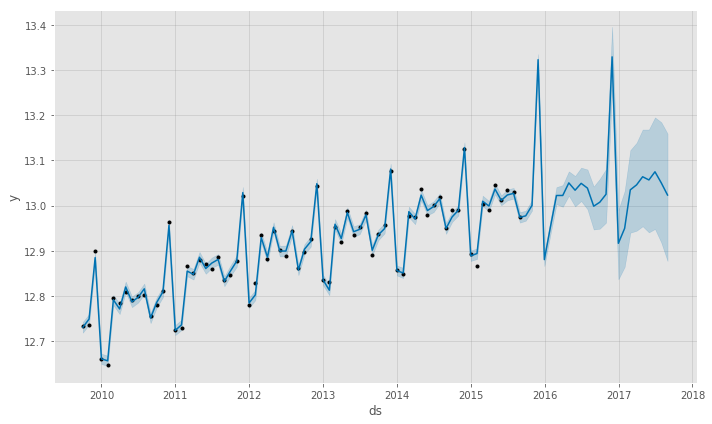

In [18]:
model.plot(forecast);

Personally, I'm not a fan of this visualization but I'm not going to build my own...you can see how I do that here:
https://github.com/urgedata/pythondata/blob/master/fbprophet/fbprophet_part_one.ipynb.

Additionally, prophet let's us take a at the components of our model, including the holidays. This component plot is an important plot as it lets you see the components of your model including the trend and seasonality (identified in the ```yearly``` pane).

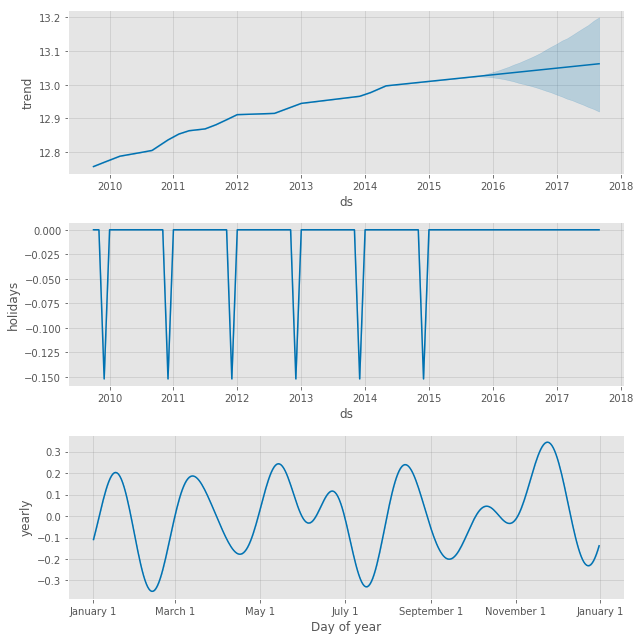

In [19]:
model.plot_components(forecast);

### Comparing holidays vs no-holidays forecasts

Let's re-run our prophet model without our promotions/holidays for comparison.

In [20]:
model_no_holiday = Prophet()
model_no_holiday.fit(df);

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\pablo\Anaconda3\envs\cnb\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [21]:
future_no_holiday = model_no_holiday.make_future_dataframe(periods=24, freq = 'm')
future_no_holiday.tail()

,ds
91,2017-04-30
92,2017-05-31
93,2017-06-30
94,2017-07-31
95,2017-08-31


In [22]:
forecast_no_holiday = model_no_holiday.predict(future)

Let's compare the two forecasts now. Note: I doubt there will be much difference in these models due to the small amount of data, but its a good example to see the process. We'll set the indexes and then join the forecast dataframes into a new dataframe called 'compared_df'.

In [23]:
forecast.set_index('ds', inplace=True)
forecast_no_holiday.set_index('ds', inplace=True)
compared_df = forecast.join(forecast_no_holiday, rsuffix="_no_holiday")

We are only really insterested in the yhat values, so let's remove all the rest and convert the logged values back to their original scale.

In [24]:
compared_df= np.exp(compared_df[['yhat', 'yhat_no_holiday']])


Now, let's take the percentage difference and the average difference for the model with holidays vs that without.

In [25]:
compared_df['diff_per'] = 100*(compared_df['yhat'] - compared_df['yhat_no_holiday']) / compared_df['yhat_no_holiday']
compared_df.tail()

,yhat,yhat_no_holiday,diff_per
ds,,,
2017-04-30,471639.693342,471507.711796,0.027991
2017-05-31,468307.717558,468143.982427,0.034975
2017-06-30,476857.011708,476847.493212,0.001996
2017-07-31,465326.105406,465480.150343,-0.033094
2017-08-31,452921.995964,453082.970637,-0.035529


In [26]:
compared_df['diff_per'].mean()

0.34423690578460314

This isn't an enormous differnece, (<1%) but there is some difference between using holidays and not using holidays.

If you know there are holidays or events happening that might help/hurt your forecasting efforts, prophet allows you to easily incorporate them into your modeling.